# Applications of  distributed Torch systems

In this notebook , I try to implement generic INTEL classification project using torch framework and  then create a multi gpu implementation of it to analyze the training speeds and accuracy differences

# Loading the  INTEL Dataset from torch vision Library




In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
%matplotlib inline
%matplotlib inline

In [2]:
!CUDA_VISIBLE_DEVICES=5,6

In [3]:
import wandb
wandb.login()

wandb: Currently logged in as: vrevanuru1 (gsucoe). Use `wandb login --relogin` to force relogin


True

In [4]:
data_dir = './intel'
print(os.listdir(data_dir))

['seg_test', 'seg_train', 'seg_pred']


In [5]:

train_tfms = tt.Compose([
    tt.Resize((150, 150)),
    tt.RandomHorizontalFlip(),
    tt.ToTensor(),
#     tt.RandomErasing(inplace=True),
#     tt.Normalize((0.4332263 , 0.4585635 , 0.45523438), (0.237158  , 0.23522326, 0.24391426))
])

valid_tfms = tt.Compose([
    tt.Resize((150, 150)),
    tt.ToTensor(),
#     tt.Normalize((0.4332263 , 0.4585635 , 0.45523438), (0.237158  , 0.23522326, 0.24391426))
])

In [6]:
# PyTorch datasets
train_ds = ImageFolder(data_dir+'/seg_train/seg_train', train_tfms)
valid_ds = ImageFolder(data_dir+'/seg_test/seg_test', valid_tfms)
len(train_ds),len(valid_ds)

(14034, 3000)

In [7]:
batch_size = 64

In [8]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True,shuffle=True)

In [9]:
from tqdm import tqdm
no_of_images = 0
mean = 0.
std = 0.
for batch, _ in tqdm(train_dl):
    # Rearrange batch to be the shape of [batch_size, no_of_channels, width_of_image * height_of_image]
    batch = batch.view(batch.size(0), batch.size(1), -1)
    
    # Update total number of images
    no_of_images += batch.size(0)
    
    # Compute mean and std here
    mean += batch.mean(2).sum(0) 
    std += batch.std(2).sum(0)


mean /= no_of_images
std /= no_of_images

print("Total number of images :", no_of_images," where Mean of images across channels: ", mean , "and std of images across channels: " , std)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 220/220 [00:08<00:00, 25.39it/s]

Total number of images : 14034  where Mean of images across channels:  tensor([0.4302, 0.4575, 0.4539]) and std of images across channels:  tensor([0.2361, 0.2347, 0.2432])


In [10]:
# Get the classes
import pathlib
root = pathlib.Path('./intel/seg_train/seg_train')
classes = sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [11]:
buildings_files = os.listdir(data_dir + "/seg_train/seg_train/buildings")
print('No. of training examples for buildings:', len(buildings_files))

forest_files = os.listdir(data_dir + "/seg_train/seg_train/forest")
print('No. of training examples for forests:', len(forest_files))

glacier_files = os.listdir(data_dir + "/seg_train/seg_train/glacier")
print('No. of training examples for glaciers:', len(glacier_files))

mountain_files = os.listdir(data_dir + "/seg_train/seg_train/mountain")
print('No. of training examples for mountains:', len(mountain_files))

sea_files = os.listdir(data_dir + "/seg_train/seg_train/sea")
print('No. of training examples for seas:', len(sea_files))

street_files = os.listdir(data_dir + "/seg_train/seg_train/street")
print('No. of training examples for streets:', len(street_files))

No. of training examples for buildings: 2191
No. of training examples for forests: 2271
No. of training examples for glaciers: 2404
No. of training examples for mountains: 2512
No. of training examples for seas: 2274
No. of training examples for streets: 2382


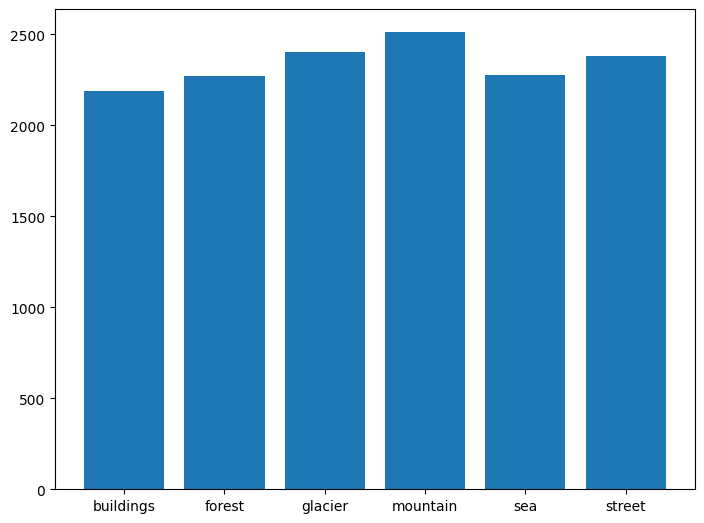

In [12]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
landscapes = [len(buildings_files),len(forest_files),len(glacier_files),len(mountain_files),len(sea_files),len(street_files)]
ax.bar(classes,landscapes)
plt.show()

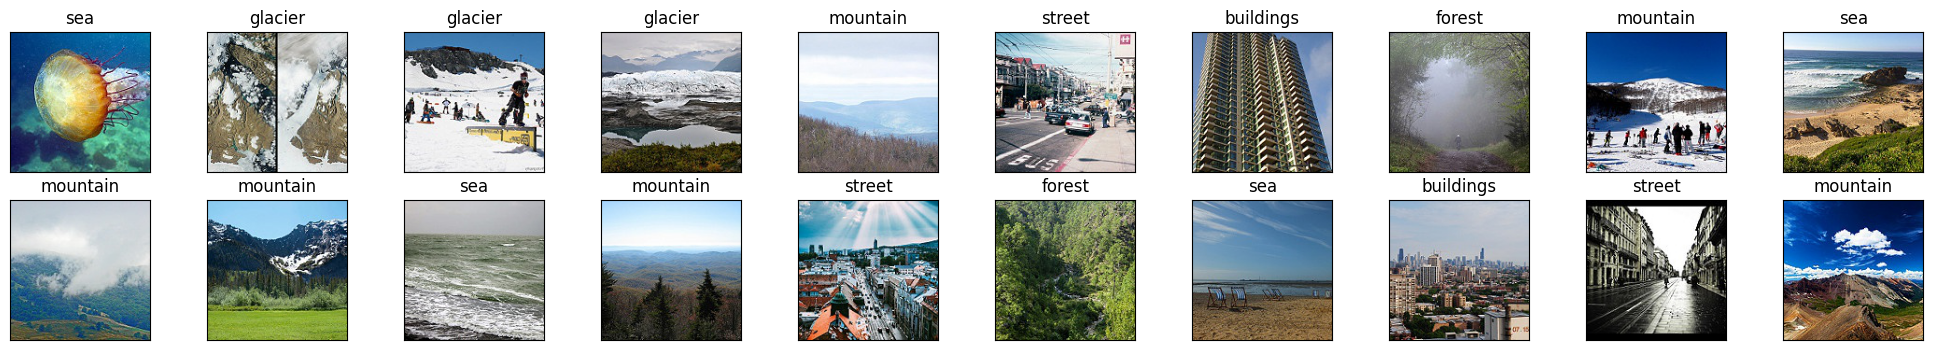

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
  '''
  Function to un-normalize and display an image
  '''
#   img = img/2 + 0.5 # un-normalize
  plt.imshow(np.transpose(img, (1, 2, 0))) # convert from tensor image
  
# Get a batch of training images
dataiter = iter(train_dl)
images, labels = next(dataiter)
images = images.cpu().data.numpy() # convert images to numpy for display

# Plot the images from the batch, along with corresponding labels
fig = plt.figure(figsize = (25, 4))

# Display 20 images
for idx in np.arange(20):
  ax = fig.add_subplot(2, int(20/2), idx+1, xticks = [], yticks = [])
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])

In [14]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

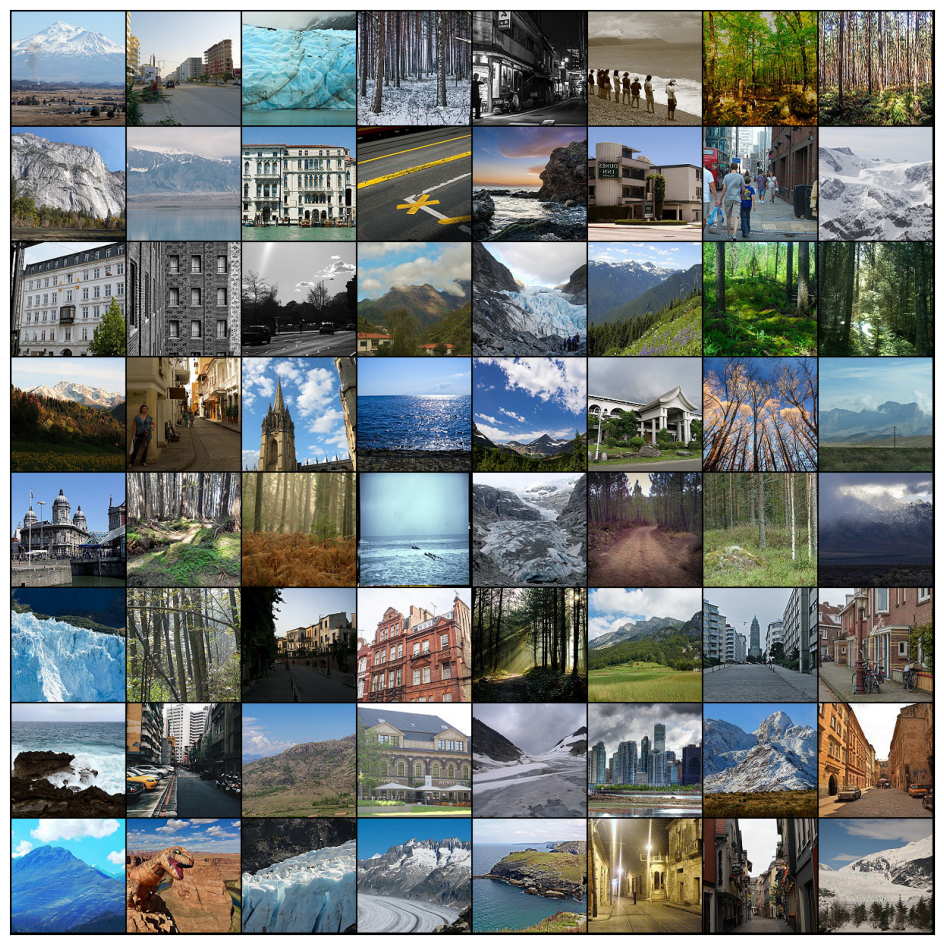

In [15]:
show_batch(train_dl)

In [16]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda:5')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [17]:
device = get_default_device()
device

device(type='cuda', index=5)

In [18]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [19]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

In [20]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
    out = simple_resnet(images)
    print(out.shape)
    break
    
del simple_resnet, images, labels
torch.cuda.empty_cache()

torch.Size([64, 3, 150, 150])


In [21]:
classes[0]

'buildings'

In [22]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc,'preds':out}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))


def log_image_table(images, predicted, labels, probs):
        "Log a wandb.Table with (img, pred, target, scores)"
        # ?? Create a wandb Table to log images, labels and predictions to
        table = wandb.Table(columns=["image", "pred", "target"]+[f"score_{classes[i]}" for i in range(6)])
    
        for img, pred, targ, prob in zip(images.to("cpu"), predicted.to("cpu"), labels.to("cpu"), probs.to("cpu")):
            # print(img.shape,type(img[0]),img[0])
            img_np =  img.numpy().transpose(1,2,0)*255
            img_np = img_np.astype(np.uint8)
            table.add_data(wandb.Image(img_np), classes[pred], classes[targ], *prob.numpy())
        wandb.log({"predictions_table":table}, commit=False)



In [23]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(8192, 6))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out


In [24]:
model1 = to_device(ResNet9(3, 6), device)
# model1 = to_device(convNet(), device)
model1

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [25]:
wandb.init(
    project="test-1runs",
    config={
        "epochs": 5,
        "batch_size": 128,
        "lr": 0.0005,
        })

In [26]:
@torch.no_grad()
def evaluate(model, val_loader,log_images=False,):
    model.eval()
    # outputs = [model.validation_step(batch) for batch in val_loader]
    outputs = []
    with torch.inference_mode():
        for step_1,batch_1 in enumerate(val_loader):
            outputs.append(model.validation_step(batch_1))
            if step_1  ==  len(val_loader)-1:
                image_1,label_1 =  batch_1
                image_1 =  image_1.to(device)
                label_1 = label_1.to(device)
                # print(image_1.shape,label_1.shape,outputs[-1]['preds'].shape,outputs[-1]['preds'].softmax(dim=1).shape)
                _,preds =  torch.max(outputs[-1]['preds'],dim=1)
                log_image_table(image_1,preds,label_1,outputs[-1]['preds'].softmax(dim=1))          
    
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        
        steps  = 0
        n_steps =  len(train_loader)

        
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            metrics =  {
                "train/train_loss":loss,
                "train/epoch":(steps + 1 + (n_steps * epoch)) / n_steps
            }
            if steps + 1 < n_steps:
                wandb.log(metrics)
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
            
            steps += 1
        
        # Validation phase
        result = evaluate(model, val_loader)

        val_metrics = { 'val/val_loss':result['val_loss'],
                        'val/val_accuracy' : result['val_acc']
                    }
        wandb.log(val_metrics)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [27]:
# for step,(image,label) in enumerate(train_dl):
#     print(type((image,label)))

for step,batch in enumerate(train_dl):
    if step==0:
        image,label = batch
        print(image)
        print(label)
        break



tensor([[[[0.1451, 0.1451, 0.1529,  ..., 0.1333, 0.1333, 0.1333],
          [0.1490, 0.1529, 0.1608,  ..., 0.1373, 0.1373, 0.1373],
          [0.1647, 0.1647, 0.1686,  ..., 0.1373, 0.1373, 0.1373],
          ...,
          [0.2314, 0.1451, 0.1647,  ..., 0.5608, 0.3882, 0.4157],
          [0.1843, 0.1922, 0.1804,  ..., 0.5686, 0.5333, 0.4588],
          [0.1882, 0.1647, 0.1451,  ..., 0.8471, 0.7176, 0.4275]],

         [[0.6784, 0.6784, 0.6784,  ..., 0.6706, 0.6706, 0.6706],
          [0.6745, 0.6784, 0.6784,  ..., 0.6745, 0.6745, 0.6745],
          [0.6706, 0.6706, 0.6745,  ..., 0.6745, 0.6745, 0.6745],
          ...,
          [0.2471, 0.1569, 0.1765,  ..., 0.4941, 0.3529, 0.4078],
          [0.2039, 0.2118, 0.1961,  ..., 0.4863, 0.4863, 0.4588],
          [0.2118, 0.1882, 0.1647,  ..., 0.7451, 0.6627, 0.4314]],

         [[0.8275, 0.8275, 0.8275,  ..., 0.8431, 0.8431, 0.8431],
          [0.8235, 0.8275, 0.8314,  ..., 0.8392, 0.8392, 0.8392],
          [0.8275, 0.8275, 0.8314,  ..., 0

In [28]:
history = [evaluate(model1, valid_dl)]
history

[{'val_loss': 1.7923622131347656, 'val_acc': 0.1667596697807312}]

In [29]:
# epochs = 1
import random
max_lr = 0.0005
grad_clip = 0.2
weight_decay = 1e-5
opt_func = torch.optim.Adam





In [30]:
config = wandb.config
config

{'epochs': 5, 'batch_size': 128, 'lr': 0.0005}

In [31]:
epochs =  config.epochs
max_lr = config.lr
# opt_func =  config.opt_func


In [32]:
type(max_lr)

float

In [33]:
%%time
history = fit_one_cycle(epochs, max_lr, model1, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 220/220 [00:52<00:00,  4.16it/s]


Epoch [0], last_lr: 0.00038, train_loss: 0.8916, val_loss: 3.0713, val_acc: 0.4294


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 220/220 [00:52<00:00,  4.16it/s]


Epoch [1], last_lr: 0.00048, train_loss: 0.7099, val_loss: 1.0313, val_acc: 0.6881


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 220/220 [00:52<00:00,  4.15it/s]


Epoch [2], last_lr: 0.00031, train_loss: 0.4806, val_loss: 0.4606, val_acc: 0.8335


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 220/220 [00:53<00:00,  4.15it/s]


Epoch [3], last_lr: 0.00009, train_loss: 0.3599, val_loss: 0.3754, val_acc: 0.8703


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 220/220 [00:52<00:00,  4.16it/s]


Epoch [4], last_lr: 0.00000, train_loss: 0.2620, val_loss: 0.3173, val_acc: 0.8907
CPU times: user 3min 44s, sys: 1min 22s, total: 5min 7s
Wall time: 4min 47s
